Santeri Hynninen

CASE: F1 EMILIA-ROMAGNAN GP 2024
GOAL: Predict the top 5 drivers for the race

APPROACH

First thoughts: The tracks, cars and drivers are different are changing every time: not that much datapoints
                The track characteristics could have big impact of how well the car and the driver performs
                We should compare the drivers performance to the track characterictics

DATA Sources:    GeoJson data from the most of the tracks: https://github.com/bacinger/f1-circuits/tree/master/circuits
                 Race statistics from: https://github.com/f1db/f1db/

                Final dataframe should be something like
                Year, Driver, Team, Weather(maybe), n x (different track attributes), placement

RESTRICTIONS:   There have been large changes to the cars in season 2022, thus we will use data only from seasons 2022-2024
                Tiremanufacturer is Pirel for every driver

TRACK ATTRIBUTES:       We would like to have the charestics of track - what are these charestics?
                        Note that we dont have to project the geodata because we are looking relative attributes of the data
                        Straights: 
                        Curves:  [over40, over30, over15, avg, stdev, avg_diff, stdev_diff]

HOW SPECIAL CASES ARE HANDELED:
                        Categorial data(engine manufacturer and driver) are one hot encoded: https://en.wikipedia.org/wiki/One-hot
                        (each category value is changed to truth column)

                        NAs(only in position column when the driver did not finish)
                        These values are removed because the prediction is impossible
                

In [70]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import math
import statistics as stat
import os
from sklearn.preprocessing import minmax_scale

In [71]:
def pointDistance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [72]:
def geoDataImport(filename = r"data\circuits\ae-2009.geojson"):
    gdata = gpd.read_file(filename)
    points = gdata['geometry'][0].coords[:]
    straight = []

    straight.append(pointDistance(points[0],points[1]))
    for i in range(1, len(points)-1):
        straight.append(pointDistance(points[i],points[i+1]))
    
    return gdata['Name'][0], round(max(straight)*10**5,2)

In [73]:
track_names = {
    'Bahrain International Circuit': 'bahrain',
    'Jeddah Corniche Circuit': 'jeddah',
    'Suzuka International Racing Course': 'suzuka',
    'Albert Park Circuit': 'melbourne',
    'Yas Marina Circuit': 'yas-marina',
    'Autódromo José Carlos Pace - Interlagos': 'interlagos',
    'Autódromo Hermanos Rodríguez': 'mexico-city',
    'Circuit of the Americas': 'austin',
    'Marina Bay Street Circuit': 'marina-bay',
    'Autodromo Nazionale Monza': 'monza',
    'Circuit Zandvoort': 'zandvoort',
    'Circuit de Spa-Francorchamps': 'spa-francorchamps',
    'Hungaroring': 'hungaroring',
    'Red Bull Ring': 'spielberg',
    'Silverstone Circuit': 'silverstone',
    'Circuit Gilles-Villeneuve': 'montreal',
    'Baku City Circuit': 'baku',
    'Circuit de Monaco': 'monaco',
    'Circuit de Barcelona-Catalunya': 'catalunya',
    'Miami International Autodrome': 'miami',
    'Circuit Paul Ricard': 'paul-ricard',
    'Autodromo Enzo e Dino Ferrari': 'imola',
    'Losail International Circuit': 'losail',
    'Las Vegas Street Circuit': 'las-vegas',
    'Shanghai International Circuit': 'shanghai'
}

def TrackData():
    columns = ('Name','max_straight')
    df = pd.DataFrame(columns=columns)
    arr = os.listdir('data\\circuits\\')
    for file in arr:
        name, max_straight = (geoDataImport('data\\circuits\\'+file))
        try:
            name = track_names[name]
        except KeyError:
            continue

        df_temp = pd.DataFrame([list((name, max_straight))], columns=df.columns)
        df = pd.concat([df, df_temp])
    df['max_straight'] = df['max_straight'].apply(lambda x:  (x-df['max_straight'].min())/(df['max_straight'].max()-df['max_straight'].min()))
    return df   



In [75]:
def racePlacement():
    df = pd.read_csv(r'data\f1db-races-race-results.csv')
    df = df[['raceId','year','positionNumber', 'driverId']]
    df = df[df['year'].isin([2024, 2023, 2022])]
    return df

In [76]:
def raceTracks():    
    df = pd.read_csv(r'data\f1db-races.csv')
    df = df[['id','year','circuitId']]
    df = df[df['year'].isin([2024, 2023, 2022])].drop('year', axis=1)
    return df

In [77]:
def dataBuilder():

    df_placement = racePlacement()
    df_idToTrack = raceTracks()
    df_trackData = TrackData()


    df = df_placement.merge(df_idToTrack, how='left', left_on='raceId', right_on='id')
    df = df.merge(df_trackData, how='left', left_on='circuitId', right_on='Name')
    df = df.drop(['raceId','id','circuitId'], axis=1)

    #Find all drivers that race 2024
    mask = racePlacement()
    mask = mask[mask['year'] == 2024] 
    drivers = mask['driverId'].unique()
    df = df[df['driverId'].isin(drivers)]

    #One-hot encoding, changing categorial columns to boolean columns
    df = pd.get_dummies(df, columns=["driverId","Name"])
    
    
    
    df = df.dropna(axis=0, how='any')
    return df

In [78]:
print(dataBuilder().columns)

Index(['year', 'positionNumber', 'max_straight', 'driverId_alexander-albon',
       'driverId_carlos-sainz-jr', 'driverId_charles-leclerc',
       'driverId_daniel-ricciardo', 'driverId_esteban-ocon',
       'driverId_fernando-alonso', 'driverId_george-russell',
       'driverId_guanyu-zhou', 'driverId_kevin-magnussen',
       'driverId_lance-stroll', 'driverId_lando-norris',
       'driverId_lewis-hamilton', 'driverId_logan-sargeant',
       'driverId_max-verstappen', 'driverId_nico-hulkenberg',
       'driverId_oliver-bearman', 'driverId_oscar-piastri',
       'driverId_pierre-gasly', 'driverId_sergio-perez',
       'driverId_valtteri-bottas', 'driverId_yuki-tsunoda', 'Name_austin',
       'Name_bahrain', 'Name_baku', 'Name_catalunya', 'Name_hungaroring',
       'Name_imola', 'Name_interlagos', 'Name_jeddah', 'Name_las-vegas',
       'Name_losail', 'Name_marina-bay', 'Name_melbourne', 'Name_mexico-city',
       'Name_miami', 'Name_monaco', 'Name_montreal', 'Name_monza',
       'Name_

BUILDING THE MODEL

Now we have the data, and we can start the model process.
I chose a pretty iterating process where I iterated trough small steps in aims to increase the accuracy score

ITR 1: First try

GradientBoostingClassifier (0.11520467836257309, 3.375438596491228), n=10
RandomForestClassifier     (0.12222222222222222, 3.3169590643274853) n=10
MLPClassifier              (0.06608187134502924, 5.315204678362573) n=10

IRT 2: More data, experimenting different models
Scaled values, added more date(all to way to year 2020)
GradientBoostingClassifier (0.12105263157894736, 3.325146198830409), n=10
RandomForestClassifier     (0.11345029239766082, 3.3947368421052633) n=10
MLPClassifier              (0.0871345029239766, 4.700584795321637) n=10
SVM                        (0.03742690058479532, 5.387134502923977) n=10

RESULT: minimal increases, can be due to low sample size

IRT 3: Ensemble
Changed to using multiple models:
                    rfModel = RandomForestClassifier()
                    gbModel = GradientBoostingClassifier()
                    gnbModel= GaussianNB()  
                    knModel = KNeighborsClassifier()
                    lrModel = LogisticRegression()
                    dcModel = DecisionTreeClassifier()
soft voting
Model                       (0.13450292397660818, 3.2923976608187133) n=1
RESULT: Better results, over 13% score from multiple runs

IRT 4: Map attributes
    1 step: remove all map attributes => Increase to around 18%
    2 step: keep selected ones (Max_straight)=> Increase to above 20%(highest try was 25%)

IRT 5: Drivers that are not racing anymore
    The accuracy dropped when the retired drivers were removed from the training set

In [79]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
def visualize(y_test, y_pred, label):
    score_df = pd.DataFrame({'test': y_test, 'pred': y_pred, 'diff':y_test-y_pred})
    agg_df = score_df.groupby(['test', 'pred']).size().reset_index(name='count')
    sns.scatterplot(x='test', y='pred', size='count', data=agg_df)
    x_values = np.linspace(agg_df['test'].min(), agg_df['test'].max(), 10)
    plt.plot(x_values, x_values, color='red', linestyle='-')
    plt.title(label)
    plt.show()
   

In [81]:
def dataSplit(i):
    df = dataBuilder()
    x, y = df.drop('positionNumber', axis=1), df['positionNumber']
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=i)
    return x_train, x_test, y_train, y_test

In [82]:
def modelFitter(i = 1):
    x_train, x_test, y_train, y_test = dataSplit(i)
    rfModel = RandomForestClassifier()
    gbModel = GradientBoostingClassifier() 
    dcModel = DecisionTreeClassifier()

    models = VotingClassifier(estimators=[
                                ('rf', rfModel),
                                ('dcModel', dcModel),
                                ('gb', gbModel)
                            ], voting='soft')

    y_pred = models.fit(x_train, y_train).predict(x_test)
    visualize(y_test, y_pred, label='Main model')
    print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
    scores = {}
    for name, model in models.named_estimators_.items():
        y_pred = model.predict(x_test)

        scores[name] = accuracy_score(y_test, y_pred)
        #visualize(y_test, y_pred, label=name)
        print(name, accuracy_score(y_test, y_pred))
    return models
    

Model is now fitted

Next step is to create the data for the upcoming event and predict the outcome

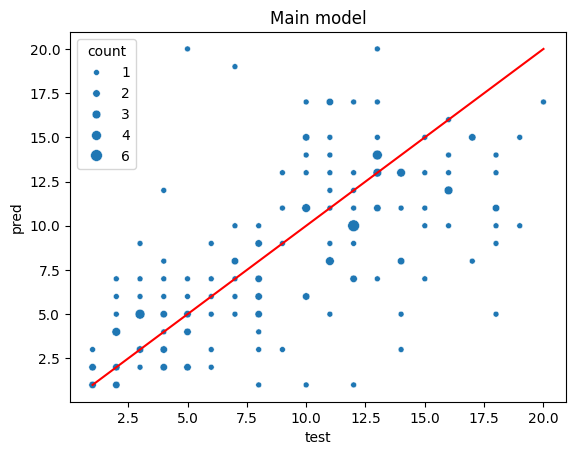

Accuracy of ensembled model: 0.12101910828025478
rf 0.10191082802547771
dcModel 0.10828025477707007
gb 0.11464968152866242


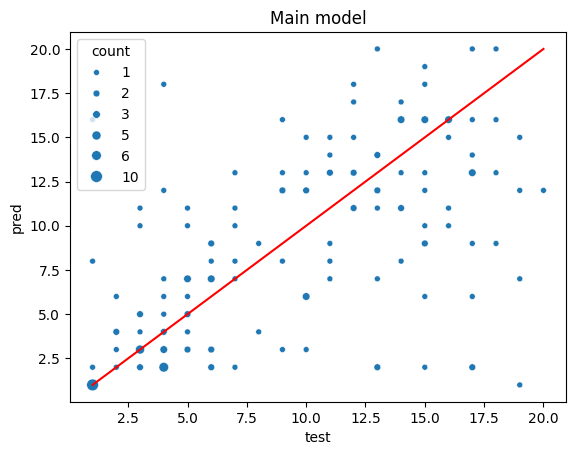

Accuracy of ensembled model: 0.15286624203821655
rf 0.06369426751592357
dcModel 0.10828025477707007
gb 0.08280254777070063


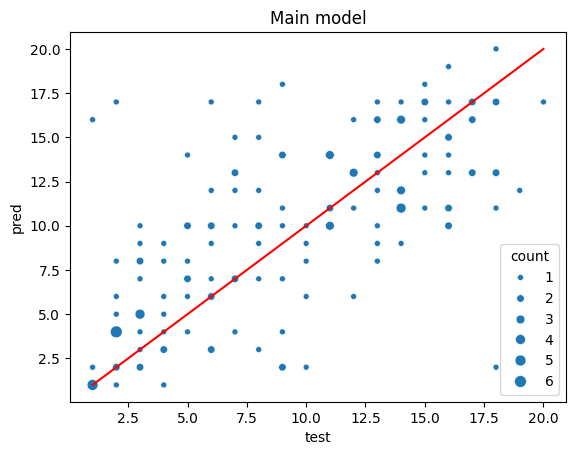

Accuracy of ensembled model: 0.12101910828025478
rf 0.12101910828025478
dcModel 0.09554140127388536
gb 0.10828025477707007


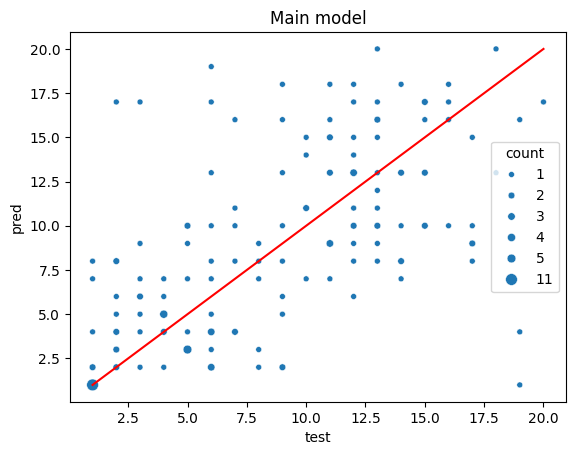

Accuracy of ensembled model: 0.11464968152866242
rf 0.11464968152866242
dcModel 0.12101910828025478
gb 0.14012738853503184


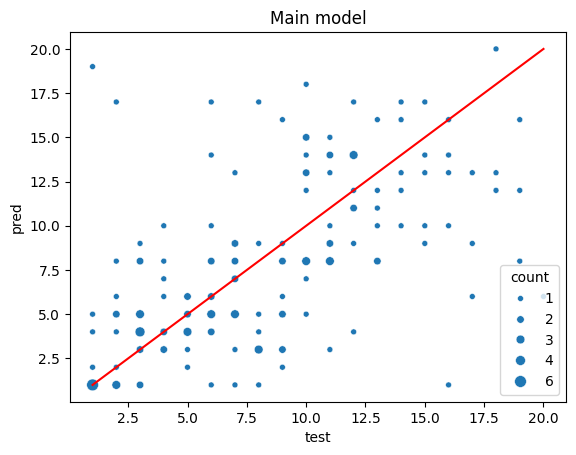

Accuracy of ensembled model: 0.12738853503184713
rf 0.05732484076433121
dcModel 0.06369426751592357
gb 0.12101910828025478
      year  max_straight  driverId_carlos-sainz-jr  driverId_charles-leclerc  \
13  2024.0           1.0                       0.0                       0.0   
18  2024.0           1.0                       0.0                       0.0   
1   2024.0           1.0                       1.0                       0.0   
6   2024.0           1.0                       0.0                       0.0   
2   2024.0           1.0                       0.0                       1.0   

    driverId_george-russell  driverId_max-verstappen  driverId_sergio-perez  \
13                      0.0                      1.0                    0.0   
18                      0.0                      0.0                    1.0   
1                       0.0                      0.0                    0.0   
6                       1.0                      0.0                    0.0   
2

In [86]:
columns = list(dataBuilder().columns)
columns.remove('positionNumber')
driver_list = columns[2:]
driver_len = len(driver_list)

track_df = TrackData()
track_df = track_df[track_df['Name'] == 'miami']

array = np.column_stack((np.full(driver_len, 2024), np.full(driver_len, track_df.head()['max_straight']), np.eye(driver_len)))

race_df = pd.DataFrame(array)
race_df = race_df.set_axis(columns, axis=1)
race_df['Name_miami'] = 1


race_df['result'] = 0
iterations = 5
for i in range(iterations):
    model = modelFitter(i)
    y_pred = model.predict(race_df.drop('result', axis=1))
    race_df['result'] = race_df['result'] + y_pred
race_df['result'] = race_df['result']/iterations
race_df = race_df.sort_values('result').head(5)
race_df = race_df.loc[:, (race_df != 0).any(axis=0)]
print(race_df)